In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
colors = {
    0: 'red',
    1: 'green',
    2: 'blue'
}

def create_example(x, y):
    c = np.random.randint(0, 3)
    image = np.zeros((28,28,3))
    image[:, :, c] += x / 255.
    return image, y, c

digit: 6, color: red


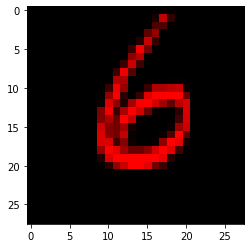

In [4]:
# sample of the dataset
index = np.random.randint(0, len(x_train))
x, y, c = create_example(x_train[index], y_train[index])

print(f'digit: {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

In [5]:
def generate_data(x, y, batch_size=128):
    num_examples = len(y)
    
    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size, ))
        c_batch = np.zeros((batch_size, ))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color

        yield x_batch, [y_batch, c_batch]

In [6]:
num_filters = 32

input_ = tf.keras.layers.Input(shape=(28, 28, 3), name='input')

conv_1 = tf.keras.layers.Conv2D(num_filters, 3, name='conv_1')(input_)
act_1 = tf.keras.layers.Activation('relu', name='act_1')(conv_1)

pool_1 = tf.keras.layers.MaxPool2D(4, name='pool_1')(act_1)
flat_1 = tf.keras.layers.Flatten(name='flat_1')(pool_1)

conv_2 = tf.keras.layers.Conv2D(num_filters, 3, padding='same', name='conv_2')(act_1)
act_2 = tf.keras.layers.Activation('relu', name='act_2')(conv_2)

conv_3 = tf.keras.layers.Conv2D(num_filters, 3, padding='same', name='conv_3')(act_2)
add = tf.keras.layers.Add(name='add')([act_1, conv_3])

act_3 = tf.keras.layers.Activation('relu', name='act_3')(add)
pool_2 = tf.keras.layers.MaxPool2D(4, name='pool_2')(act_3)

flat_2 = tf.keras.layers.Flatten(name='flat_2')(pool_2)

digit = tf.keras.layers.Dense(10, activation='softmax', name='digit')(flat_2)
color = tf.keras.layers.Dense(3, activation='softmax', name='color')(flat_1)

model = tf.keras.models.Model(input_, [digit, color])

model.compile(
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'color': 'sparse_categorical_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 26, 26, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
act_1 (Activation)              (None, 26, 26, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 26, 26, 32)   9248        act_1[0][0]                      
______________________________________________________________________________________________

In [7]:
train_gen = generate_data(x_train, y_train)
val_gen = generate_data(x_test, y_test)

_ = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=468,
    validation_steps=78,
    epochs=10
)

Epoch 1/10
468/468 [==============================] - 11s 14ms/step - loss: 0.8650 - digit_loss: 0.6976 - color_loss: 0.1674 - digit_accuracy: 0.7837 - color_accuracy: 0.9630 - val_loss: 0.0821 - val_digit_loss: 0.0812 - val_color_loss: 8.7985e-04 - val_digit_accuracy: 0.9730 - val_color_accuracy: 1.0000
Epoch 2/10
468/468 [==============================] - 6s 12ms/step - loss: 0.0926 - digit_loss: 0.0919 - color_loss: 6.5180e-04 - digit_accuracy: 0.9727 - color_accuracy: 1.0000 - val_loss: 0.0552 - val_digit_loss: 0.0550 - val_color_loss: 2.8694e-04 - val_digit_accuracy: 0.9827 - val_color_accuracy: 1.0000
Epoch 3/10
468/468 [==============================] - 6s 12ms/step - loss: 0.0552 - digit_loss: 0.0549 - color_loss: 2.3875e-04 - digit_accuracy: 0.9825 - color_accuracy: 1.0000 - val_loss: 0.0513 - val_digit_loss: 0.0511 - val_color_loss: 1.7461e-04 - val_digit_accuracy: 0.9818 - val_color_accuracy: 1.0000
Epoch 4/10
468/468 [==============================] - 6s 12ms/step - loss: 0

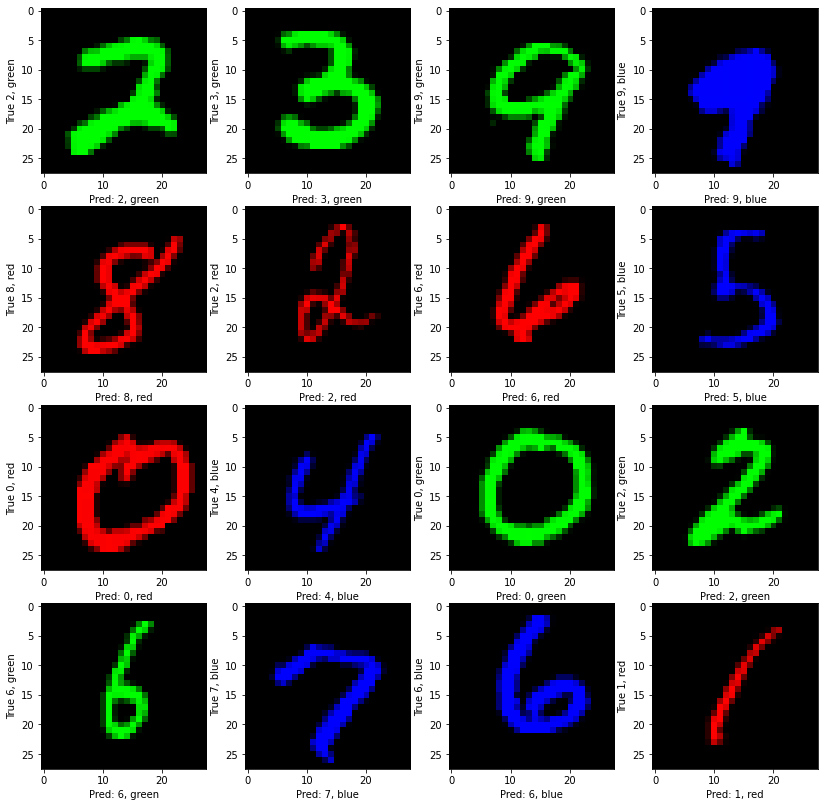

In [8]:
# display the results

data = generate_data(x_test, y_test, batch_size= 16)
x, [y, c] = next(data)

preds = model.predict(x)
plt.figure(figsize=(14,14))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[i])
    pred_digit = np.argmax(preds[0][i])
    pred_color = np.argmax(preds[1][i])
    
    plt.ylabel(f'True {int(y[i])}, {colors[c[i]]}')
    plt.xlabel(f'Pred: {int(pred_digit)}, {colors[pred_color]}')
plt.show()